# Model Validation with Calibration

**Modular Version - Reorganized by Code Type**

This notebook uses 3 utility modules organized by code type:
- **`validation_metrics.py`** - Pure calculation logic (PSI, ECE, Brier)
- **`validation_wrappers.py`** - Model wrappers (Calibration, SHAP, Anomaly)
- **`validation_plots.py`** - All visualization functions

This structure:
1. Keeps calculations separate from visualization
2. Combines related model operations in one place
3. Minimizes import statements

---

## Setup and Imports

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import joblib
import warnings
warnings.filterwarnings('ignore')

# Metrics module - pure calculations
from sklearn.metrics import roc_auc_score, brier_score_loss
from validation_metrics import (
    calculate_ece, calculate_psi, calculate_feature_psi
)

# Wrappers module - calibration, SHAP, anomaly detection
from validation_wrappers import (
    # Calibration
    apply_sigmoid_calibration,
    # SHAP
    compute_shap_values, calculate_feature_importance,
    explain_individual_prediction,
    # Anomaly
    train_anomaly_detector, detect_anomalies,
    analyze_anomaly_performance
)

# Plots module - all visualizations
from validation_plots import (
    plot_calibration_curves, plot_roc_and_distributions,
    plot_psi_analysis, plot_shap_summary,
    plot_shap_feature_importance, plot_shap_waterfall,
    plot_anomaly_analysis
)

# Plotting setup
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ All modules loaded successfully")

✓ All modules loaded successfully


## 1. Load Data and Models

In [2]:
# Load models
loaded_lr = joblib.load('final_lr_model.pkl')
loaded_xgb = joblib.load('final_xgb_model.pkl')
loaded_scaler = joblib.load('final_scaler.pkl')

# Load datasets
X_train = pd.read_csv('X_train_final.csv')
y_train = pd.read_csv('y_train_final.csv').values.ravel()

X_val = pd.read_csv('X_val_final.csv')
y_val = pd.read_csv('y_val_final.csv').values.ravel()

X_test = pd.read_csv('X_test_final.csv')
y_test = pd.read_csv('y_test_final.csv').values.ravel()

# Scale data
X_train_scaled = pd.DataFrame(
    loaded_scaler.transform(X_train), 
    columns=X_train.columns
)
X_val_scaled = pd.DataFrame(
    loaded_scaler.transform(X_val), 
    columns=X_val.columns
)
X_test_scaled = pd.DataFrame(
    loaded_scaler.transform(X_test), 
    columns=X_test.columns
)

print(f"✓ Data loaded and scaled")
print(f"  Train: {X_train.shape} | Val: {X_val.shape} | Test: {X_test.shape}")
print(f"  Default rate - Train: {y_train.mean():.2%}, Val: {y_val.mean():.2%}, Test: {y_test.mean():.2%}")

✓ Data loaded and scaled
  Train: (700, 12) | Val: (150, 12) | Test: (150, 12)
  Default rate - Train: 30.00%, Val: 30.00%, Test: 30.00%


## 2. Apply Sigmoid Calibration (Platt Scaling)

In [3]:
# Original models
models = {
    'Logistic Regression': loaded_lr,
    'XGBoost': loaded_xgb
}

# Apply calibration
calibrated_models = apply_sigmoid_calibration(
    models, X_train_scaled, y_train, cv=5, ensemble=True
)

All models calibrated


## 3. Compare Calibration Metrics

In [4]:
datasets = {
    'Train': (X_train_scaled, y_train),
    'Val': (X_val_scaled, y_val),
    'Test': (X_test_scaled, y_test)
}
results =[]

# Compare before/after calibration
for model_name in models.keys():
    for data_name, (X,y) in datasets.items():
        # Original model
        prob_orig = models[model_name].predict_proba(X)[:,1]
        auc_orig = roc_auc_score(y, prob_orig)
        brier_orig = brier_score_loss(y, prob_orig)
        ece_orig = calculate_ece(y, prob_orig)
        
        # Calibrated model
        prob_cal = calibrated_models[model_name].predict_proba(X)[:, 1]
        auc_cal = roc_auc_score(y, prob_cal)
        brier_cal = brier_score_loss(y, prob_cal)
        ece_cal = calculate_ece(y, prob_cal)

        # Store results
        results.append({
                'Model': model_name,
                'Type': 'Original',
                'Dataset': data_name,
                'AUC': auc_orig,
                'Brier': brier_orig,
                'ECE': ece_orig,
            })
        results.append({
                'Model': model_name,
                'Type': 'Calibrated',
                'Dataset': data_name,
                'AUC': auc_cal,
                'Brier': brier_cal,
                'ECE': ece_cal,
            })
results = pd.DataFrame(results)

In [5]:
print('    - AUC: Should remain similar (calibration preserves ranking)')
print('    - Brier Score: Lower is better (should improve with calibration)')
print("    - ECE < 0.05: Well calibrated | 0.05-0.15: Fair | > 0.15: Poor")
results.head(12)

    - AUC: Should remain similar (calibration preserves ranking)
    - Brier Score: Lower is better (should improve with calibration)
    - ECE < 0.05: Well calibrated | 0.05-0.15: Fair | > 0.15: Poor


,Model,Type,Dataset,AUC,Brier,ECE
0,Logistic Regression,Original,Train,0.796215,0.185448,0.148090
1,Logistic Regression,Calibrated,Train,0.796361,0.162428,0.030833
2,Logistic Regression,Original,Val,0.762540,0.205340,0.179827
3,Logistic Regression,Calibrated,Val,0.761693,0.169772,0.042190
4,Logistic Regression,Original,Test,0.804233,0.180800,0.153420
5,Logistic Regression,Calibrated,Test,0.805291,0.154680,0.069520
6,XGBoost,Original,Train,0.907721,0.124976,0.104453
7,XGBoost,Calibrated,Train,0.902065,0.129320,0.115258
8,XGBoost,Original,Val,0.696931,0.190852,0.050632
9,XGBoost,Calibrated,Val,0.701799,0.189175,0.050081


## 4. Visualize Calibration Improvement

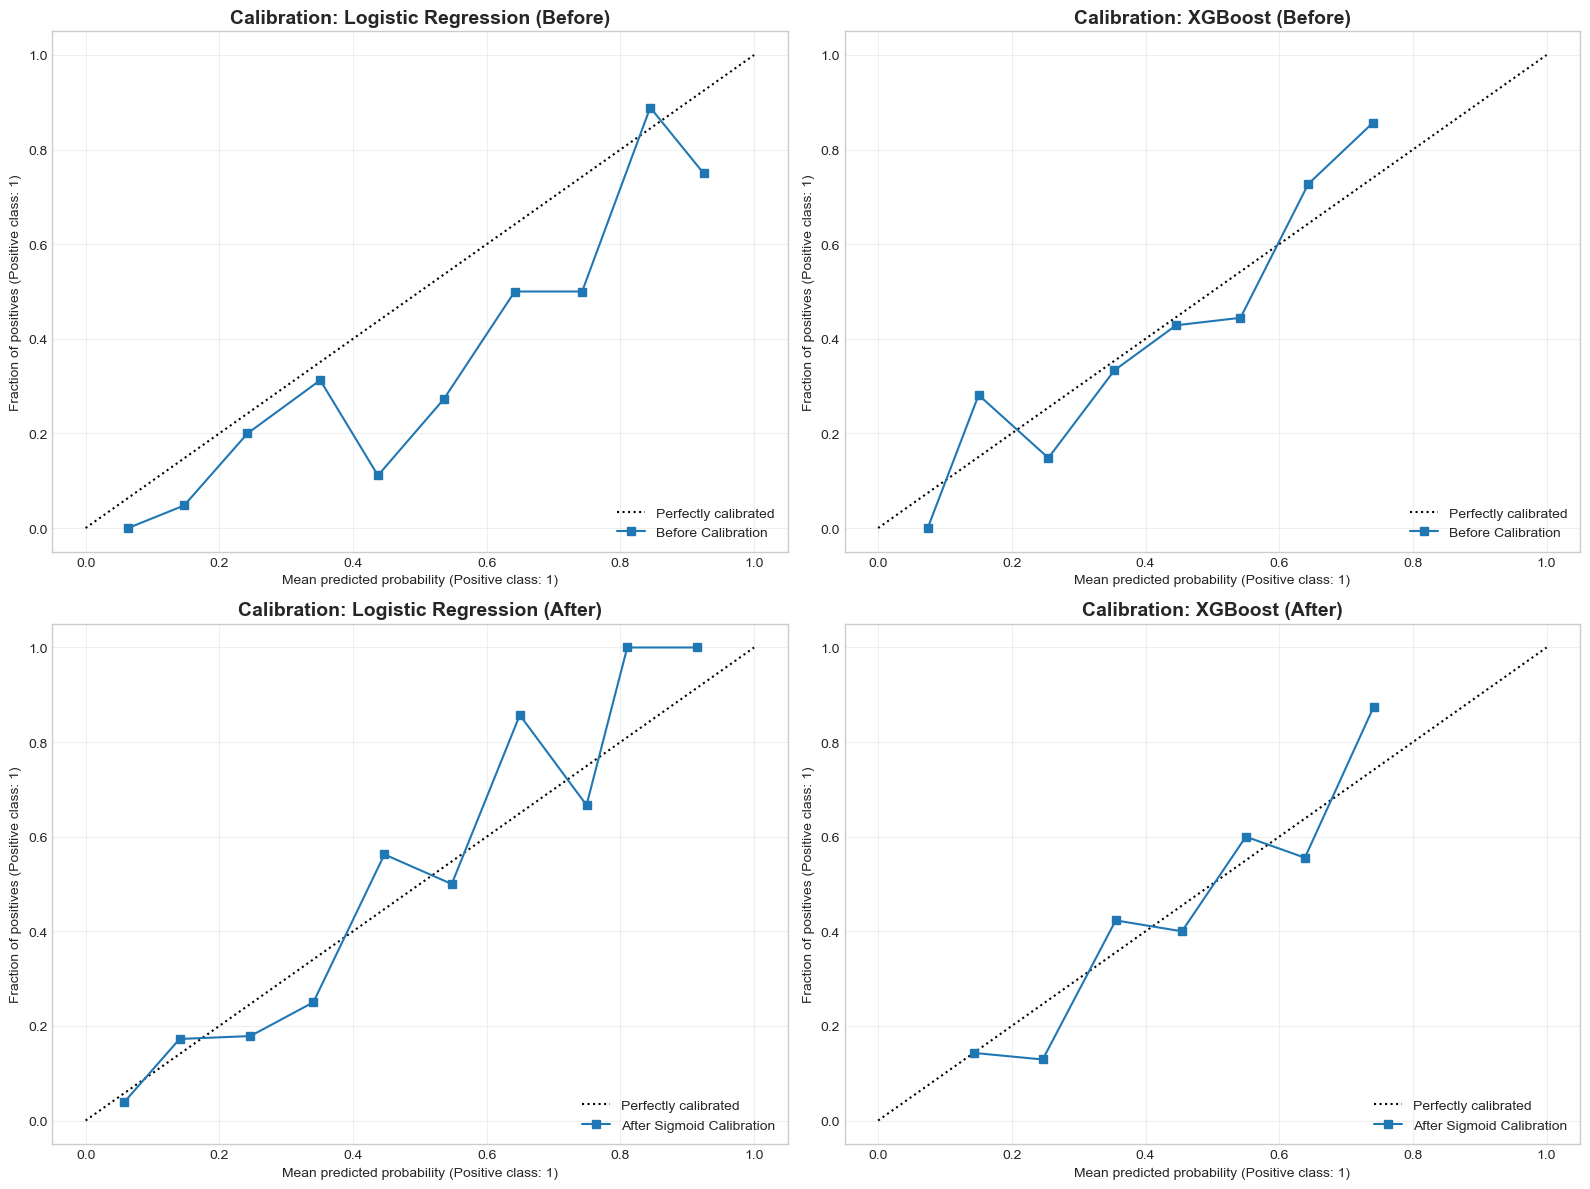

In [6]:
# Calibration curves (before/after)
plot_calibration_curves(models, calibrated_models, X_test_scaled, y_test)

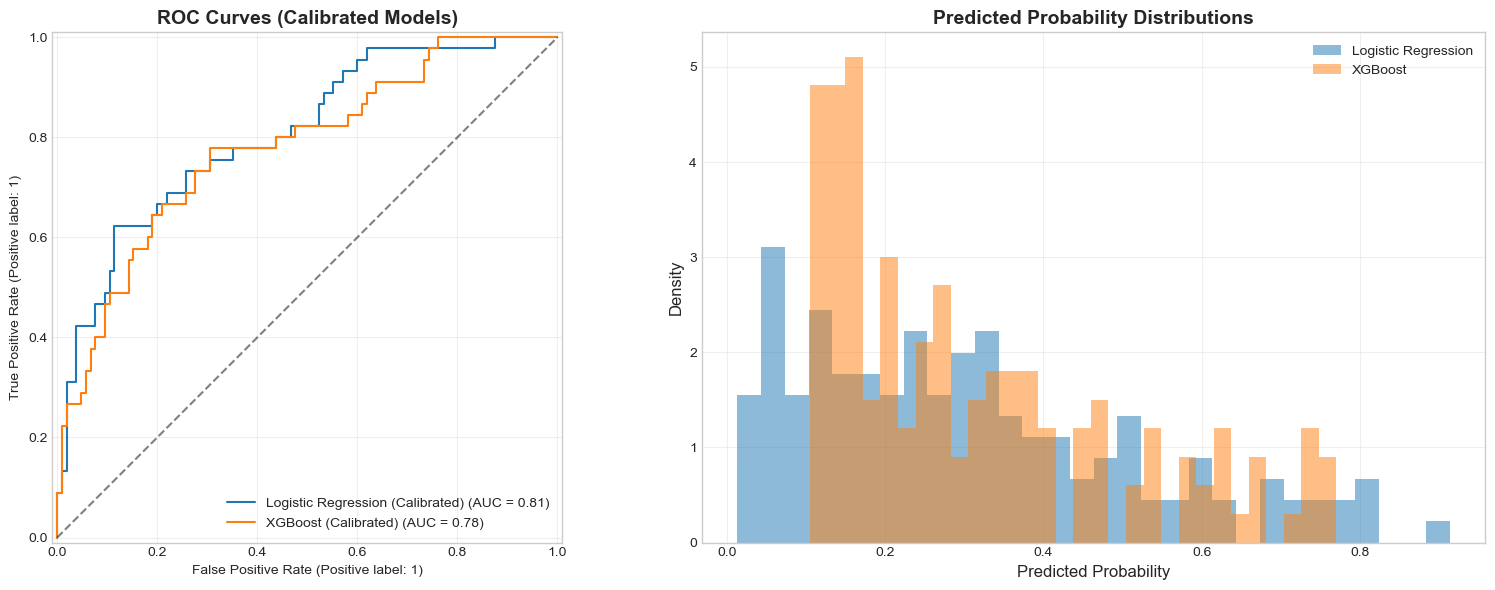

In [7]:
# ROC curves and probability distributions
plot_roc_and_distributions(calibrated_models, X_test_scaled, y_test)

## 5. Population Stability Index (PSI)

In [8]:
# Feature-level PSI
print("Feature-Level PSI (Train vs Test):\n")
psi_df = calculate_feature_psi(X_train, X_test)
print(psi_df.to_string(index=False))


Feature-Level PSI (Train vs Test):

                Feature      PSI
                age_woe 0.089464
   installment_rate_woe 0.060143
     credit_history_woe 0.037921
            purpose_woe 0.033743
 property_magnitude_woe 0.019370
           duration_woe 0.009573
            housing_woe 0.006736
    personal_status_woe 0.003175
         employment_woe 0.002778
      credit_amount_woe 0.000457
     savings_status_woe 0.000110
other_payment_plans_woe 0.000000


Since all of PSI is less than 0.01, our model is stable.

In [9]:

train_pred_xgb = calibrated_models['XGBoost'].predict_proba(X_train_scaled)[:, 1]
test_pred_xgb = calibrated_models['XGBoost'].predict_proba(X_test_scaled)[:, 1]
train_pred_lr = calibrated_models['Logistic Regression'].predict_proba(X_train_scaled)[:,1]
test_pred_lr =  calibrated_models['Logistic Regression'].predict_proba(X_test_scaled)[:,1]

psi_scores = {}
psi_scores['XGBoost_test'] = calculate_psi(train_pred_xgb, test_pred_xgb)
psi_scores['Logistic_test'] = calculate_psi(train_pred_lr, test_pred_lr)

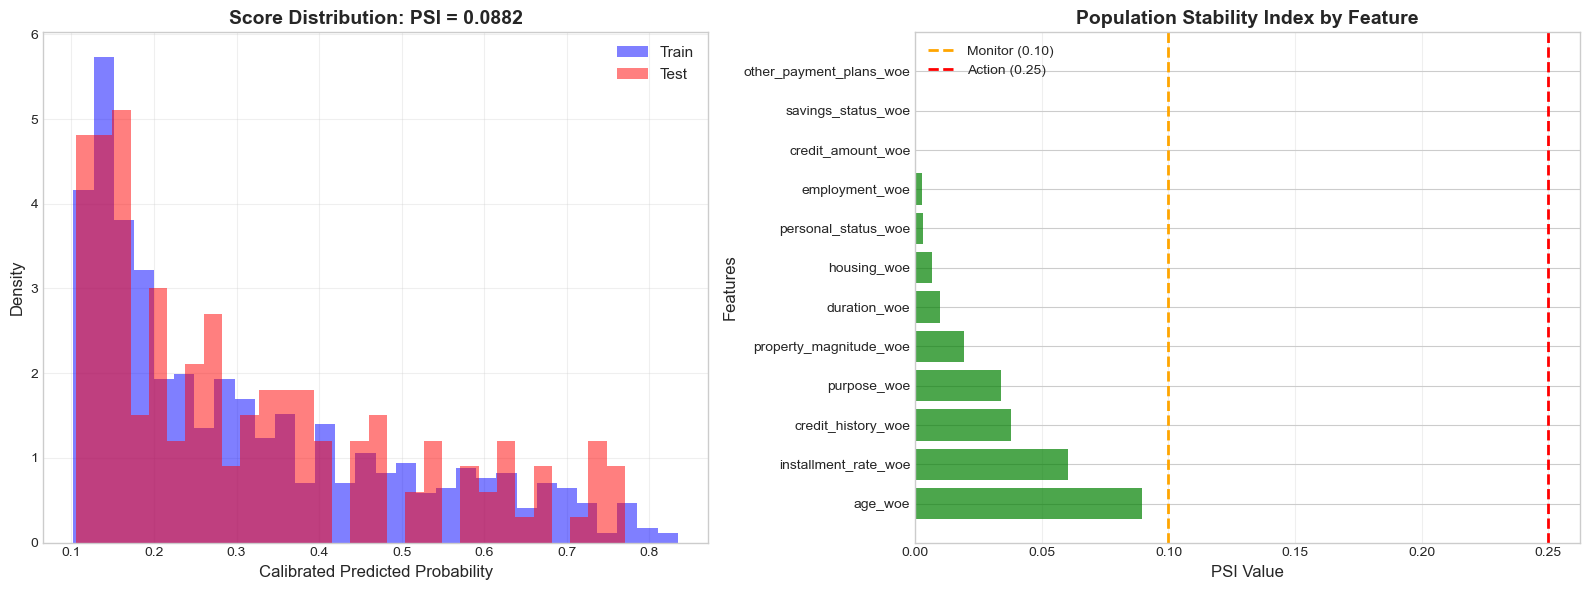

In [10]:
plot_psi_analysis(
    train_pred_xgb, test_pred_xgb, 
    psi_df, psi_scores['XGBoost_test']
)

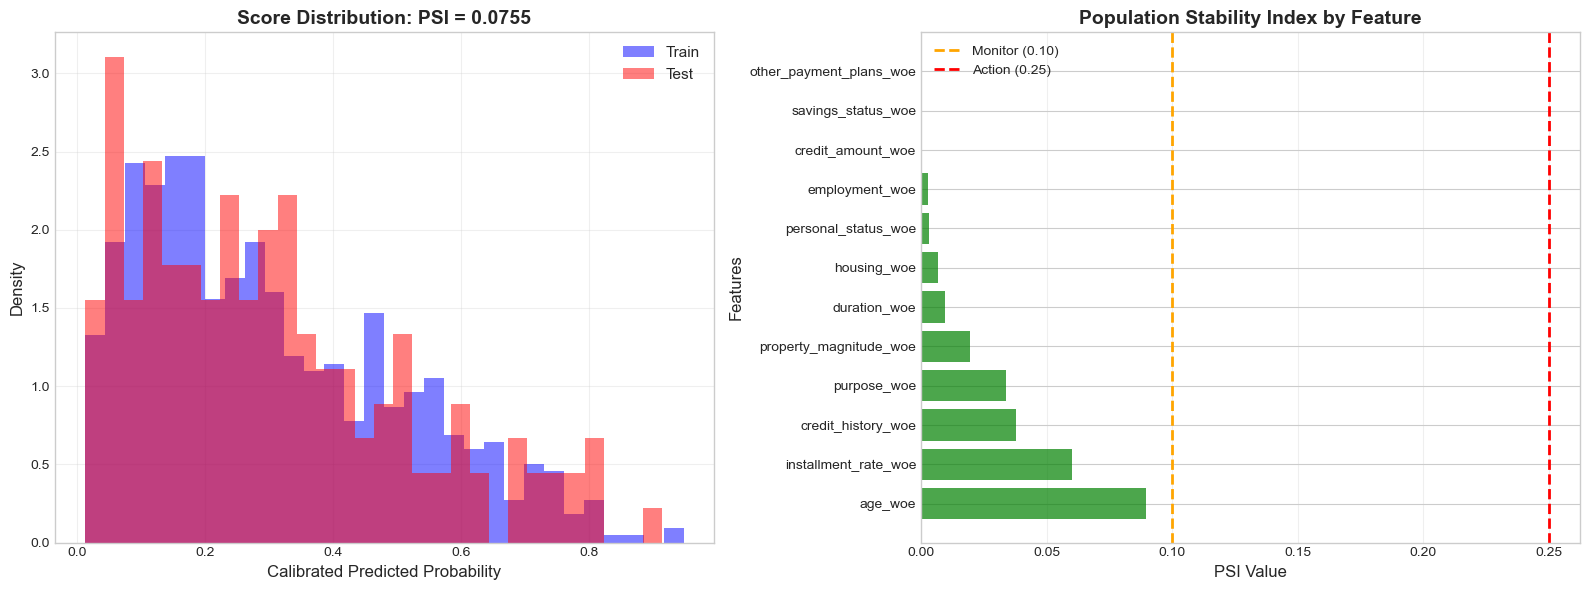

In [11]:
plot_psi_analysis(
    train_pred_lr, test_pred_lr, 
    psi_df, psi_scores['Logistic_test']
)

## 6. SHAP Explainability

In [12]:
# Compute SHAP values
explainer, shap_values, X_shap_sample = compute_shap_values(
    calibrated_models['XGBoost'],
    X_train_scaled,
    X_test_scaled,
    sample_size=200,
    n_background=100,
    nsamples=100
)

  0%|          | 0/150 [00:00<?, ?it/s]

 Efficiency axiom satisfied


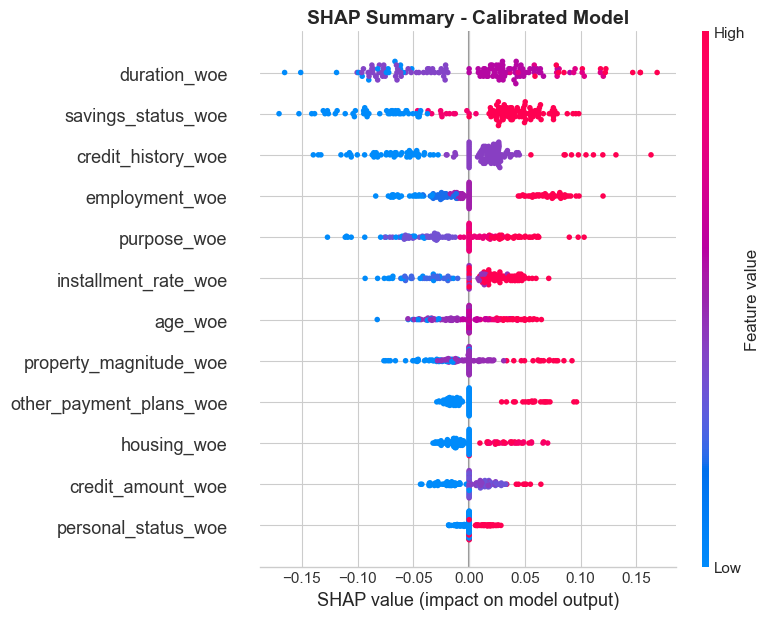

In [13]:
# SHAP summary plot
plot_shap_summary(shap_values, X_shap_sample)

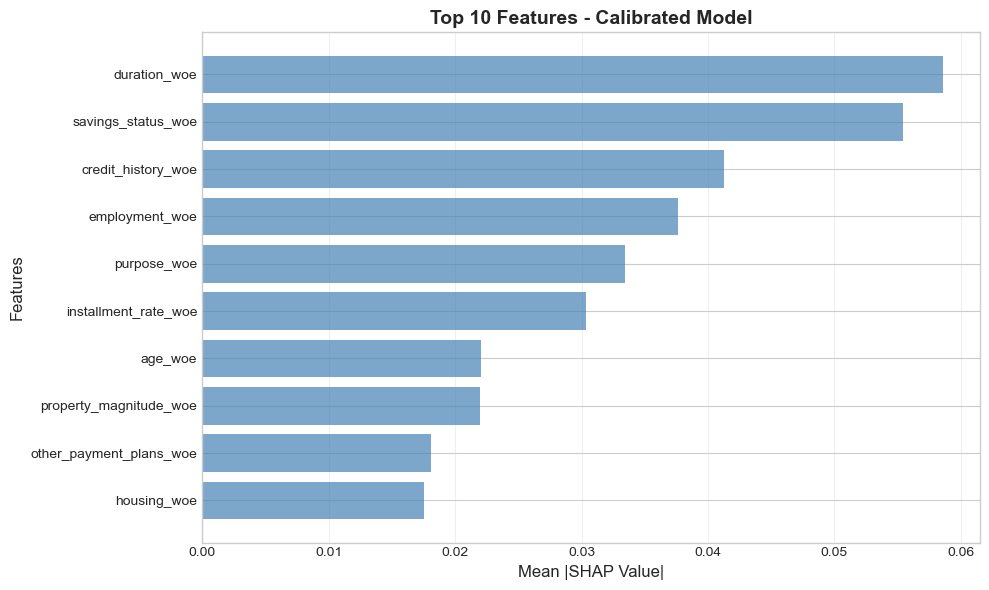

In [14]:
# Feature importance
importance_df = calculate_feature_importance(shap_values, X_shap_sample.columns.tolist())

# Visualize top features
plot_shap_feature_importance(importance_df, top_n=10)

In [15]:
# Individual prediction explanation
y_shap_sample = y_test[X_shap_sample.index]

contribution_df = explain_individual_prediction(
    shap_values, X_shap_sample, y_shap_sample,
    calibrated_models['Logistic Regression']
)
y_pred = calibrated_models['Logistic Regression'].predict_proba(X_shap_sample)[:,1]
idx = y_pred.argmax()
print(f' Loan #{X_shap_sample.index[idx]}')
print(f' Calibrated PD: {y_pred[idx]:.2%}')
print(f' Actual outcome: {'Default' if y_shap_sample[idx] ==1 else 'Repaid'}')

 Loan #2
 Calibrated PD: 91.40%
 Actual outcome: Default


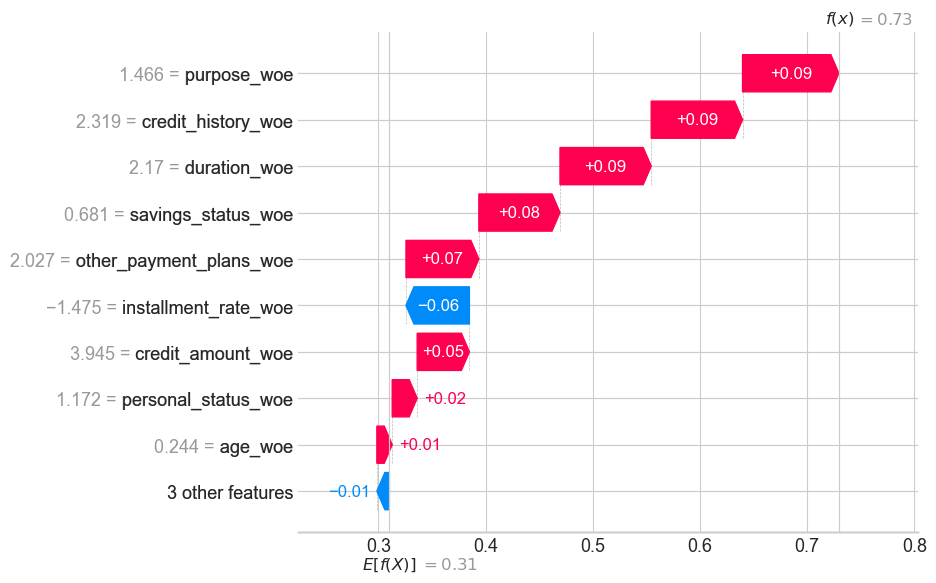

In [18]:
# Waterfall plot
plot_shap_waterfall(shap_values, X_shap_sample, explainer, idx=idx)

## 7. Anomaly Detection

In [19]:
# Train anomaly detector
iso_forest = train_anomaly_detector(
    X_train_scaled,
    contamination=0.05,
    n_estimators=100
)

In [20]:
# Detect anomalies
datasets_anomaly = {
    'Train': X_train_scaled,
    'Val': X_val_scaled,
    'Test': X_test_scaled
}

anomaly_results = detect_anomalies(iso_forest, datasets_anomaly)

In [21]:
# Analyze performance on normal vs anomalous observations
default_rate_normal, default_rate_anomaly, auc_normal, auc_anomaly, ece_normal, ece_anomaly = analyze_anomaly_performance(
        anomaly_results, y_test,
        calibrated_models['Logistic Regression'],
        X_test_scaled
    )
print(" Performance Comparison:\n")
print("-"*70)
print(f"{'Subset':<20} | {'N':<8} | {'Default Rate':<15} | {'AUC':<10} | {'ECE':<10}")
print("-"*70)
print(f"{'Normal':<20} | {(anomaly_results['Test']['predictions'] == 1).sum():<8} | {default_rate_normal:>12.2%}    | {auc_normal:.4f}     | {ece_normal:.4f}")
print(f"{'Anomalous':<20} | {(anomaly_results['Test']['predictions'] == -1).sum():<8} | {default_rate_anomaly:>12.2%}    | {auc_anomaly:.4f}     | {ece_anomaly:.4f}")
print(f"{'All':<20} | {len(y_test):<8} | {y_test.mean():>12.2%}    | {roc_auc_score(y_test,calibrated_models['Logistic Regression'].predict_proba(X_test)[:,1] ):.4f}     | {calculate_ece(y_test,calibrated_models['Logistic Regression'].predict_proba(X_test)[:,1] ):.4f}")
print("-"*70)

 Performance Comparison:

----------------------------------------------------------------------
Subset               | N        | Default Rate    | AUC        | ECE       
----------------------------------------------------------------------
Normal               | 144      |       27.78%    | 0.8087     | 0.0699
Anomalous            | 6        |       83.33%    | 0.2000     | 0.5182
All                  | 150      |       30.00%    | 0.8068     | 0.1181
----------------------------------------------------------------------


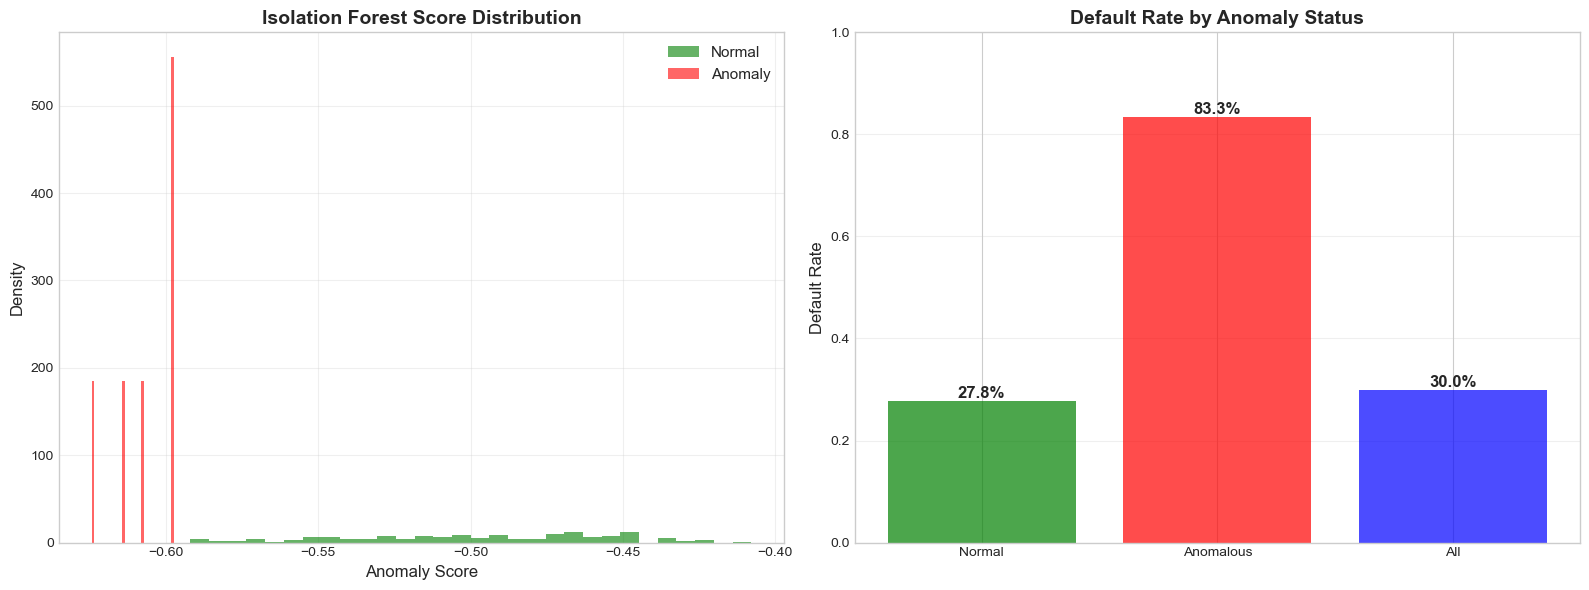

In [24]:
# Visualize anomaly analysis
plot_anomaly_analysis(
    anomaly_results, y_test,
    default_rate_normal, default_rate_anomaly
)